In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [4]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector

# import basic plot tools
from qiskit.visualization import plot_histogram

lightout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]

In [22]:
    def qRAM(ad,tile):
        qc = QuantumCircuit(ad, tile)
        ##address 00->tile lightsout[0]
        qc.x([ad[0],ad[1]])
        i=0
        for lightout in lightout4[0]:
            if lightout==1:
                qc.ccx(ad[0],ad[1],tile[i])
            i=i+1
        qc.x([ad[0],ad[1]])
    
        ##address 01->tile lightsout[1]
        qc.x(ad[1])
        i=0
        for lightout in lightout4[1]:
            if lightout==1:
                qc.ccx(ad[0],ad[1],tile[i])
            i=i+1
        qc.x(ad[1])

        ##address 10->tile lightsout[2]
        qc.x(ad[0])
        i=0
        for lightout in lightout4[2]:
            if lightout==1:
                qc.ccx(ad[0],ad[1],tile[i])
            i=i+1
        qc.x(ad[0])

        ##address 11->tile lightsout[3]
        i=0
        for lightout in lightout4[3]:
            if lightout==1:
                qc.ccx(ad[0],ad[1],tile[i])
            i=i+1
    
        U_s = qc.to_gate()
        U_s.name = "$U_qram$"
        return U_s
    
    def nine_mct(control_qubits,ancilla_qubits,output_qubit):
        qc = QuantumCircuit(control_qubits, ancilla_qubits, output_qubit)
        qc.mct([control_qubits[0],control_qubits[1],control_qubits[2]],ancilla_qubits[0],mode='noancilla')
        qc.mct([control_qubits[3],control_qubits[4],control_qubits[5]],ancilla_qubits[1],mode='noancilla')
        qc.mct([control_qubits[6],control_qubits[7],control_qubits[8]],ancilla_qubits[2],mode='noancilla')
        qc.mct([ancilla_qubits[0],ancilla_qubits[1],ancilla_qubits[2]],output_qubit[0],mode='noancilla')
        qc.mct([control_qubits[6],control_qubits[7],control_qubits[8]],ancilla_qubits[2],mode='noancilla')
        qc.mct([control_qubits[3],control_qubits[4],control_qubits[5]],ancilla_qubits[1],mode='noancilla')
        qc.mct([control_qubits[0],control_qubits[1],control_qubits[2]],ancilla_qubits[0],mode='noancilla')
        U_s = qc.to_gate()
        U_s.name = "$U_9mct$"
        return U_s
    
    def oracle_2a(tile,flip,flag_a,ancilla):
        qc = QuantumCircuit(tile,flip,flag_a,ancilla)
        #build lightsout_oracle
        switch_list=[[1,3],[0,2,4],[1,5],[0,4,6],[1,3,5,7],[2,4,8],[3,7],[4,6,8],[5,7]]
        
        i=0
        for clights in switch_list:
            qc.cx(flip[8-i],tile[i])
            for clight in clights:
                qc.cx(flip[8-i],tile[clight])
            i=i+1
        
        for i in range(9):
            qc.x(tile[i])
        
        qc.append(nine_mct(tile,ancilla,flag_a),[*range(9),*range(19,25),18])
        
        for i in range(9):
            qc.x(tile[i])
            
        i=0
        for clights in switch_list:
            qc.cx(flip[8-i],tile[i])
            for clight in clights:
                qc.cx(flip[8-i],tile[clight])
            i=i+1
        U_s = qc.to_gate()
        U_s.name = "$U_ora2a$"
        return U_s
    
    def eight_mct_in(in_qubits,ancilla_qubits):
        qc = QuantumCircuit(in_qubits, ancilla_qubits)    
        qc.mct([in_qubits[0],in_qubits[1],in_qubits[2]],ancilla_qubits[0],mode='noancilla')
        qc.mct([in_qubits[3],in_qubits[4],in_qubits[5]],ancilla_qubits[1],mode='noancilla')
        qc.ccx(in_qubits[6],in_qubits[7],ancilla_qubits[2])
        qc.mct([ancilla_qubits[0],ancilla_qubits[1],ancilla_qubits[2]],in_qubits[8],mode='noancilla')
        qc.ccx(in_qubits[6],in_qubits[7],ancilla_qubits[2])
        qc.mct([in_qubits[3],in_qubits[4],in_qubits[5]],ancilla_qubits[1],mode='noancilla')
        qc.mct([in_qubits[0],in_qubits[1],in_qubits[2]],ancilla_qubits[0],mode='noancilla')
        U_s = qc.to_gate()
        U_s.name = "$U_8mct$"
        return U_s
    
    def nine_diffuser(flip_qubits,ancilla_qubits):
        qc = QuantumCircuit(flip_qubits,ancilla_qubits)  
        # Apply transformation |s> -> |00..0> (H-gates)
        for qubit in range(9):
            qc.h(qubit)
        # Apply transformation |00..0> -> |11..1> (X-gates)
        for qubit in range(9):
            qc.x(qubit)
        # Do multi-controlled-Z gate
        qc.h(8)
        qc.append(eight_mct_in(flip_qubits,ancilla_qubits),[*range(15)])
        qc.h(8)
        # Apply transformation |11..1> -> |00..0>
        for qubit in range(9):
            qc.x(qubit)
        # Apply transformation |00..0> -> |s>
        for qubit in range(9):
            qc.h(qubit)
        # We will return the diffuser as a gate
        U_s = qc.to_gate()
        U_s.name = "$U_9diff$"
        return U_s
    
    def u2a(tile,flip,flag_a,ancilla):
        qc = QuantumCircuit(tile,flip,flag_a,ancilla)
        for i in range(17):
            #Oracle
            qc.append(oracle_2a(tile,flip,flag_a,ancilla),[*range(25)])
            # Diffuser
            qc.append(nine_diffuser(flip,ancilla),[*range(9,18),*range(19,25)])
        U_s = qc.to_gate()
        U_s.name = "$U_2a$"
        return U_s
    
    def u2ad(tile,flip,flag_a,ancilla):
        qc = QuantumCircuit(tile,flip,flag_a,ancilla)
        for i in range(17):
            # Diffuser
            qc.append(nine_diffuser(flip,ancilla),[*range(9,18),*range(19,25)])
            #Oracle
            qc.append(oracle_2a(tile,flip,flag_a,ancilla),[*range(25)])
        U_s = qc.to_gate()
        U_s.name = "$U_2ad$"
        return U_s
    
    def counter(flip,flag_b,ancilla):
        qc = QuantumCircuit(flip,flag_b,ancilla)
        for i in range(9):
            qc.mct([flip[i],ancilla[0],ancilla[1],ancilla[2]],ancilla[3],mode='noancilla')
            qc.mct([flip[i],ancilla[0],ancilla[1]],ancilla[2],mode='noancilla')
            qc.ccx(flip[i],ancilla[0],ancilla[1])
            qc.cx(flip[i],ancilla[0])
        qc.x([ancilla[2],ancilla[3]])
        qc.ccx(ancilla[2],ancilla[3],flag_b[0])
        qc.x([ancilla[2],ancilla[3]])
        for i in range(9):
            qc.cx(flip[8-i],ancilla[0])        
            qc.ccx(flip[8-i],ancilla[0],ancilla[1])        
            qc.mct([flip[8-i],ancilla[0],ancilla[1]],ancilla[2],mode='noancilla')
            qc.mct([flip[8-i],ancilla[0],ancilla[1],ancilla[2]],ancilla[3],mode='noancilla')
        U_s = qc.to_gate()
        U_s.name = "$U_counter$"
        return U_s
    

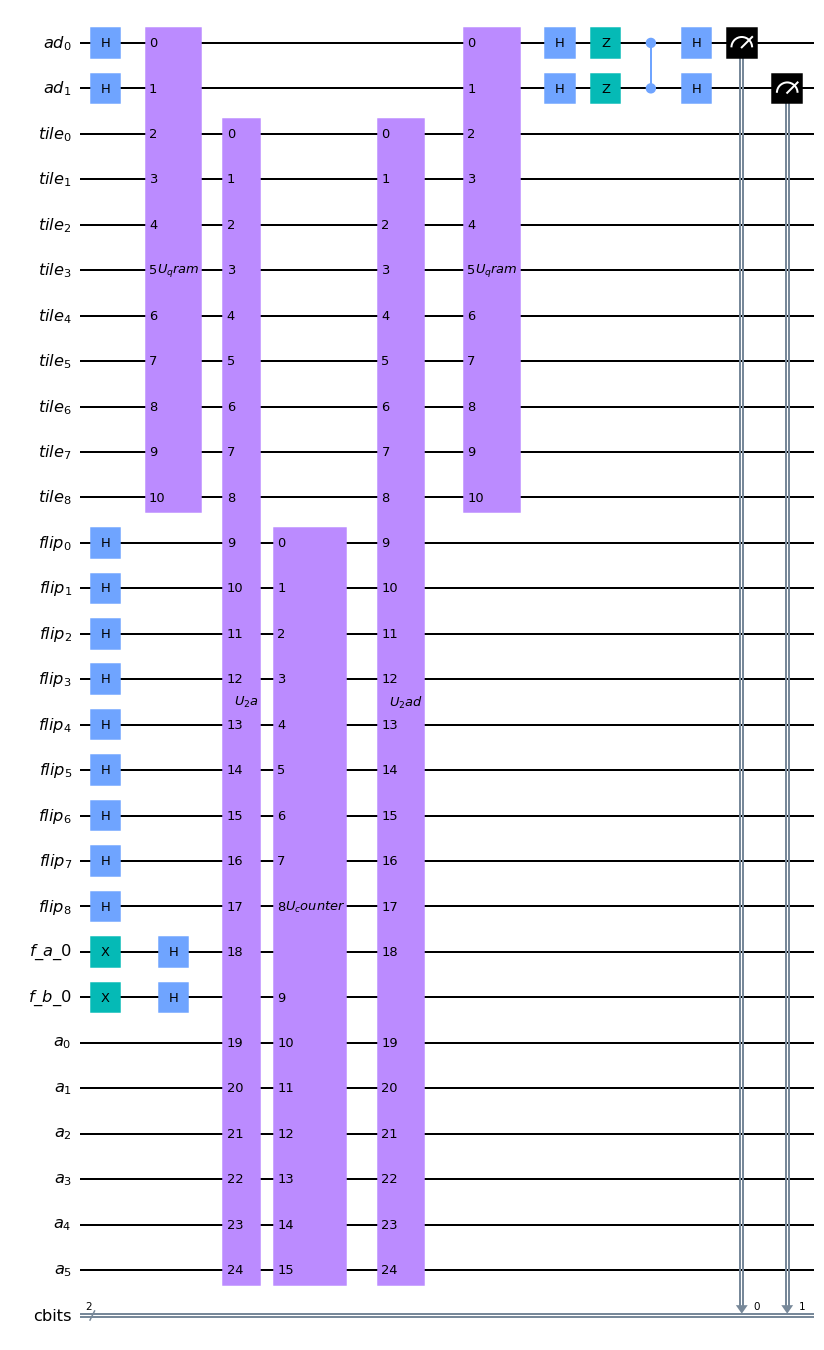

In [23]:
    ####Circuit Implement
    ad = QuantumRegister(2, name='ad')
    tile = QuantumRegister(9, name='tile')
    flip = QuantumRegister(9, name='flip')
    flag_a = QuantumRegister(1, name='f_a')
    flag_b = QuantumRegister(1, name='f_b')
    ancilla = QuantumRegister(6, name='a')
    cbits = ClassicalRegister(2, name='cbits')
    qc = QuantumCircuit(ad, tile,flip,flag_a,flag_b,ancilla,cbits)
    
    ####Initialize
    qc.h(ad)
    qc.h(flip)
    qc.x(flag_a)
    qc.h(flag_a)
    qc.x(flag_b)
    qc.h(flag_b)
    ####qRAM
    qc.append(qRAM(ad,tile),[*range(11)])
    ####u2a block
    qc.append(u2a(tile,flip,flag_a,ancilla),[*range(2,21),*range(22,28)])
    ####counter
    qc.append(counter(flip,flag_b,ancilla),[*range(11,20),*range(21,28)])
    ####u2ad block
    qc.append(u2ad(tile,flip,flag_a,ancilla),[*range(2,21),*range(22,28)])
    ####qRAM
    qc.append(qRAM(ad,tile),[*range(11)])
    ####2 qubit diffusion
    qc.h(ad)
    qc.z(ad)
    qc.cz(ad[0],ad[1])
    qc.h(ad)   
    # Measure the variable qubits
    qc.measure(ad, cbits)
    qc.draw()

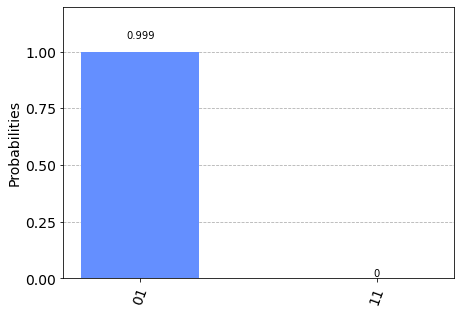

In [24]:
    ####Circuit Implement
    ad = QuantumRegister(2, name='ad')
    tile = QuantumRegister(9, name='tile')
    flip = QuantumRegister(9, name='flip')
    flag_a = QuantumRegister(1, name='f_a')
    flag_b = QuantumRegister(1, name='f_b')
    ancilla = QuantumRegister(6, name='a')
    cbits = ClassicalRegister(2, name='cbits')
    qc = QuantumCircuit(ad, tile,flip,flag_a,flag_b,ancilla,cbits)
    
    ####Initialize
    qc.h(ad)
    qc.h(flip)
    qc.x(flag_a)
    qc.h(flag_a)
    qc.x(flag_b)
    qc.h(flag_b)
    ####qRAM
    qc.append(qRAM(ad,tile),[*range(11)])
    ####u2a block
    qc.append(u2a(tile,flip,flag_a,ancilla),[*range(2,21),*range(22,28)])
    
    ####counter
    qc.append(counter(flip,flag_b,ancilla),[*range(11,20),*range(21,28)])
    
    ####u2ad block
    qc.append(u2ad(tile,flip,flag_a,ancilla),[*range(2,21),*range(22,28)])
    ####qRAM
    qc.append(qRAM(ad,tile),[*range(11)])
    ####2 qubit diffusion
    qc.h(ad)
    qc.z(ad)
    qc.cz(ad[0],ad[1])
    qc.h(ad)   
    # Measure the variable qubits
    qc.measure(ad, cbits)
    qasm_simulator = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend=qasm_simulator, shots=1024).result()
    plot_histogram(result.get_counts())